<a href="https://colab.research.google.com/github/SergioJF10/MLT-ESI-UCLM_CIS/blob/main/products/Notebooks/Models/2-TF_IDF_and_N_Grams.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TF-IDF Vectorization and N-Grams
In this colab, we will develop another apprach. It includes the TF-IDF vectorization applied with N-grams.

In [12]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier

----
_**NOTE**: We would like to highlight that, up to this point, some algorithms and models cannot be executed in the Google Colab session with an standard account. In order to mitigate that we mainly took a decision:_
1. _Use checkboxes to specify whether to execute a section or not._

# 0. Loading the Data
From the Preprocessing notebook, we obtain the following files with the data ready to be vectorized.
- x_train.json
- x_test.json
- y_train.json
- y_test.json

_Note: Please upload those four files. They can be found in the "Data/Interim" folder in the `products` project folder._

In [2]:
x_train = []
x_test = []
y_train = []
y_test = []
with open('x_train.json', 'r', encoding='utf-8') as x_train_file:
  x_train = json.load(x_train_file)
with open('x_test.json', 'r', encoding='utf-8') as x_test_file:
  x_test = json.load(x_test_file)
with open('y_train.json', 'r', encoding='utf-8') as y_train_file:
  y_train = json.load(y_train_file)
with open('y_test.json', 'r', encoding='utf-8') as y_test_file:
  y_test = json.load(y_test_file)

Once the file descriptors have been used, we will delete them to save RAM.

In [3]:
del x_test_file
del x_train_file
del y_test_file
del y_train_file

# 1. TF-IDF Vectorization and N-Grams
Let's now apply vectorization techniques over the preprocessed data in order to prepare the input for the models.

We apply the TFIDF vectorization over both, the train and the test sets according to the vocabulary from all the documents.

Note that in this case, we are obtaining an n_gram range from 1 to 3. It might take a while.

In [4]:
vectorizer = TfidfVectorizer(ngram_range=(1,3),use_idf=True, smooth_idf=True).fit(x_train + x_test)
x_train_tfidf = vectorizer.transform(x_train)
x_test_tfidf = vectorizer.transform(x_test)
x_train_tfidf

<35414x2088251 sparse matrix of type '<class 'numpy.float64'>'
	with 2963946 stored elements in Compressed Sparse Row format>

Once we have obtained the TFIDF vectorization, we have to get rid of a 70% of the total features, so, we need the best 30% of the whole list of features, let's call it $k$.

In [5]:
k = int(0.3*x_train_tfidf.shape[1])
k

626475

Let's now select the most important features for bot train and test sets.

In [6]:
selector = SelectKBest(score_func=chi2, k=k)
x_train_tfidf = selector.fit_transform(x_train_tfidf, y_train)
x_test_tfidf = selector.transform(x_test_tfidf)
x_train_tfidf.shape[1]

626475

We should highlight that, originally, the different results should be stored in different variables but, due to the huge memory consumed per each variable, we will use just one variable.

### Undersampling
_Note: In a normal Google Colab session, we cannot execute both, n-grams + tf-idf with undersampling. This might make the results a bit worse._

_For executing the undersampling, just mark the checkbox and run the below cells_.

In [7]:
exec_undersampling = True #@param {type:"boolean"}

Let's now try to apply an undersampling technique to compensate the labels.

In [19]:
if exec_undersampling: 
  # ram option selected
  x_train_df = pd.DataFrame(x_train_tfidf.toarray())
  x_train_df['label'] = y_train

  n = int(22111 * 0.3) # undersampling rate
  msk = x_train_df.groupby('label')['label'].transform('size') >= n
  x_train_df = pd.concat((x_train_df[msk].groupby('label').sample(n=n), x_train_df[~msk]), ignore_index=True)
  print(x_train_df['label'].value_counts())

Once the mask have been used, we can delete it to save RAM usage.

We will also remove the x_train and x_test variables, since they have been properly loaded and vectorized, so we can erase them.

Due to a similar reason, we can remove also the x_train_tfidf variable.

In [9]:
if exec_undersampling:
  # ram option selected
  del msk
  del x_train_tfidf
  del x_train
  del x_test

### Naive Bayes
Now, it's time to train our first model, a Naive Bayes model with a Multinomial approach, since it is the most appropriate for our case.

In [10]:
if exec_undersampling:
  # ram option selected
  mngb_model = MultinomialNB().fit(x_train_df.drop('label', axis=1), x_train_df['label'])
else:
  mngb_model = MultinomialNB().fit(x_train_tfidf, y_train)
preds = mngb_model.predict(x_test_tfidf)

It is important to remember the considerable imbalance observed in the data. Due to this reason, we will use f1 score instead of the accuracy for evaluating the model.

EVALUATION METRICS
F1 Score for the model: 0.6154302279615232
Precision for the model: 0.6154302279615232
Recall for the model: 0.6154302279615232


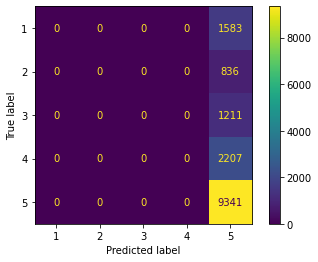

In [13]:
print('EVALUATION METRICS')
print(f'F1 Score for the model: {f1_score(y_test, preds, average="micro")}')
print(f'Precision for the model: {precision_score(y_test, preds, average="micro")}')
print(f'Recall for the model: {recall_score(y_test, preds, average="micro")}')
cm = confusion_matrix(y_test, list(preds), labels=mngb_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mngb_model.classes_) 
disp.plot()
plt.show()


We apply the TFIDF vectorization over both, the train and the test sets according to the vocabulary from all the documents. As we can see, initially, we have a precission of 61%, but the main problem comes from the huge unbalance in the data.

### Decision Tree
As we are asked to apply two models, the second one will be a decision tree. For this model, we will also try to optimize the hyperparametrization aiming to improve the accuracy.

In [14]:
dt_model = DecisionTreeClassifier(min_samples_leaf=1, max_depth=8, criterion='entropy')
if exec_undersampling:
  # ram option selected
  dt_model.fit(x_train_df.drop('label', axis=1), x_train_df['label'])
else:
  dt_model.fit(x_train_tfidf, y_train)
preds = dt_model.predict(x_test_tfidf)

Now, the same as with Naive Bayes classifier, we will check the confusion matrix as well as the f1 score.

EVALUATION METRICS
F1 Score for the model: 0.6271577282909474
Precision for the model: 0.6271577282909474
Recall for the model: 0.6271577282909474


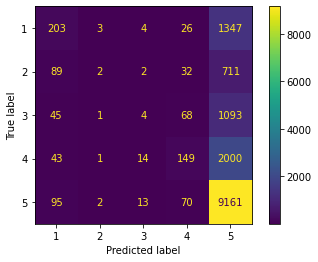

In [15]:
print('EVALUATION METRICS')
print(f'F1 Score for the model: {f1_score(y_test, preds, average="micro")}')
print(f'Precision for the model: {precision_score(y_test, preds, average="micro")}')
print(f'Recall for the model: {recall_score(y_test, preds, average="micro")}')
cm = confusion_matrix(y_test, list(preds), labels=mngb_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mngb_model.classes_) 
disp.plot()
plt.show()

## Voting Classifier

_**NOTE**: Again, due to the lack of RAM memory in an standard Google Colab account, we couldn't execute this in the notebook. We tested it in our own machines with a Python script._

_Locally, we got a $0.4833$ of accuracy with the F1 Score metric when applying the Voting classifier with undersampled data._

_Anyway, we indicate here the code for further possible executions with better accounts._

----

Aiming to improve the accuracy, we will try to apply an ensemling model, specifically a Voting Classifier.

First, we add a new model based on K Nearest Neighbors to complete the ensembler model.

In [16]:
# kNN
knn_model = KNeighborsClassifier(n_neighbors=16, weights='uniform', metric='minkowski', p=1)

Now we build the Voting Classifier model, using the models we have previously used.

In [21]:
voting_model = VotingClassifier(estimators=[('mnb', mngb_model), ('dt', dt_model), ('knn', knn_model)], voting='soft')
if exec_undersampling:
  # ram option selected
  voting_model.fit(x_train_df.drop('label', axis=1), x_train_df['label'])
else:
  voting_model.fit(x_train_tfidf, y_train)
preds = mngb_model.predict(x_test_tfidf)

preds = voting_model.predict(x_test_tfidf)

Let's check the confusion matrix and its accuracy as we did with the previous models.

EVALUATION METRICS
F1 Score for the model: 0.6154302279615232
Precision for the model: 0.6154302279615232
Recall for the model: 0.6154302279615232


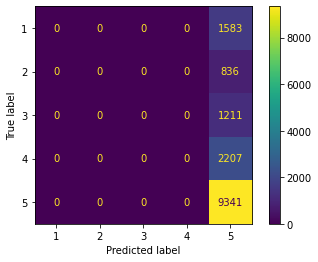

In [22]:
print('EVALUATION METRICS')
print(f'F1 Score for the model: {f1_score(y_test, preds, average="micro")}')
print(f'Precision for the model: {precision_score(y_test, preds, average="micro")}')
print(f'Recall for the model: {recall_score(y_test, preds, average="micro")}')
cm = confusion_matrix(y_test, list(preds), labels=mngb_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mngb_model.classes_) 
disp.plot()
plt.show()